In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tf.config.set_logical_device_configuration(
            gpu,
            [tf.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

data_folder = '/home/rluser/thesis_ws/src/ML_Levers_Knobs/DATA/1D_LEVER_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

# Split the data into 70% train and 30% test
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=31)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)

WS_B = 2000  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 1)

X_train1 = np.dstack((X_train[:, :, 0], X_train[:, :, 4]))
X_train2 = X_train[:, :, 0]
X_train3 = X_train[:, :, 4]

X_test1 = np.dstack((X_test[:, :, 0], X_test[:, :, 4]))
X_test2 = X_test[:, :, 0]
X_test3 = X_test[:, :, 4]

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)

print("X_test1 shape:", X_test1.shape)
print("X_test2 shape:", X_test2.shape)
print("X_test3 shape:", X_test3.shape)

DISP_LABELS = [0, 1, 2]
OUT_N = 3


2024-06-26 17:07:35.491320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 17:07:36.261718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-26 17:07:36.765766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 17:07:36.798868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (804, 2000, 9)
y_data shape: (804,)
X_data.[0] shape:  (2000, 9)
TOTAL DATA: 804  ||  Train = 70.0%  ||  Test = 30.0%
Dimensions of X_train: (562, 2000, 9)    ||  Dimensions of y_train: (562,)
Dimensions of X_test:  (242, 2000, 9)    ||  Dimensions of y_test:  (242,)
Shapes of the stacked arrays:
X_train1 shape: (562, 2000, 2)
X_train2 shape: (562, 2000)
X_train3 shape: (562, 2000)
X_test1 shape: (242, 2000, 2)
X_test2 shape: (242, 2000)
X_test3 shape: (242, 2000)


# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx

2024-06-26 17:07:42.571177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 17:07:42.571411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-26 17:07:42.571530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 200, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 97, 128)   │    131,200 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 97, 128)   │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 97, 128)   │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 97, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 97, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 97, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 96, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 96, 128)   │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 96, 128)   │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     32,832 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ dense_1[0][0]   

 Total params: 443,651 (1.69 MB)

 Trainable params: 443,651 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1719414464.989114  151403 service.cc:145] XLA service 0x7972c00015b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719414464.989159  151403 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-26 17:07:45.050811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-26 17:07:45.371366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-26 17:07:48.288572: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-26 17:07:48.498707: W external/local_tsl/tsl/framework/bfc_allocator.cc:296]

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3778 - loss: 1.0857

I0000 00:00:1719414471.302767  151403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-26 17:07:54.591781: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-26 17:07:54.758976: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-26 17:07:55.176216: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.3790 - loss: 1.0843
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3641 - loss: 1.0512
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4720 - loss: 1.0138
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4450 - loss: 1.0094
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4402 - loss: 0.9861
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6133 - loss: 0.8886
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6837 - loss: 0.7364
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6621 - loss: 0.7425
Epoch 9/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7696 - loss: 0.5168
Epoch 10/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7779 - loss: 0.4676
Epoch 11/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7585 - loss: 0.5329
Epoch 12/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7751 - loss: 0.4

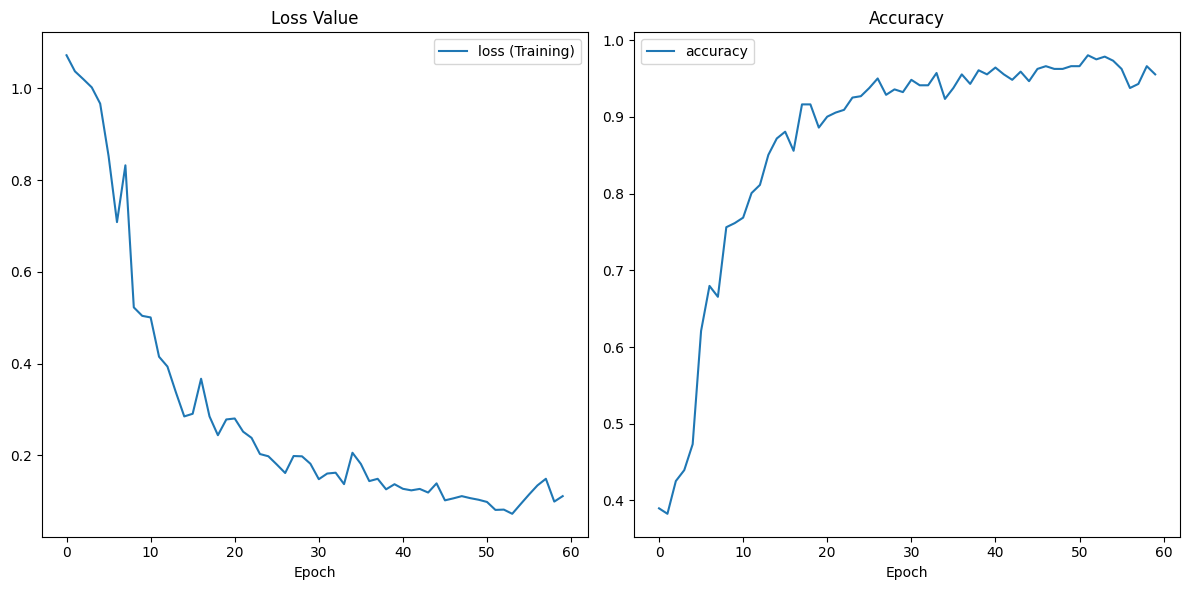

Test loss: 0.22219732403755188
Test accuracy: 0.9545454545454546
Accuracy Score: 0.9545454545454546
F1 Score: 0.9447213834899717
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       115
         1.0       0.98      0.86      0.92        70
         2.0       0.86      1.00      0.93        57

    accuracy                           0.95       242
   macro avg       0.95      0.95      0.94       242
weighted avg       0.96      0.95      0.95       242



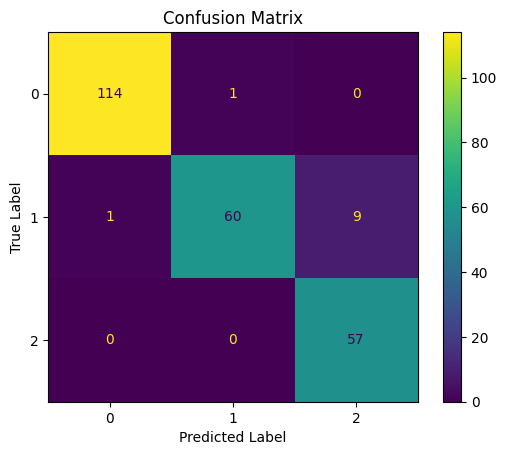

In [2]:
# Define the branched model
def build_branched_model1(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    # x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    # x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    # x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model1(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=60, batch_size=32, validation_split=0.0, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [3]:
# model_name = "FTP_LEVER_3CnvGMP_97_NOVAL"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model1)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3Conv 93% acheived

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 200, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_1       │ (None, 100, 128)  │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_1       │ (None, 100, 64)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_1       │ (None, 100, 64)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 47, 128)   │    131,200 │ maxpool1d_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 47, 128)   │     65,664 │ maxpool1d_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 47, 128)   │     65,664 │ maxpool1d_3_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 47, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 47, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 47, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 46, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 46, 128)   │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 46, 128)   │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]

 Total params: 477,507 (1.82 MB)

 Trainable params: 477,507 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.3899 - loss: 1.1147
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4542 - loss: 1.0284
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6941 - loss: 0.7750
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7350 - loss: 0.5342
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7846 - loss: 0.5018
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8099 - loss: 0.4506
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8156 - loss: 0.4112
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8095 - loss: 0.4007
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8631 - loss: 0.3474
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8645 - loss: 1.2366
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6883 - loss: 1.3472
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7664 -

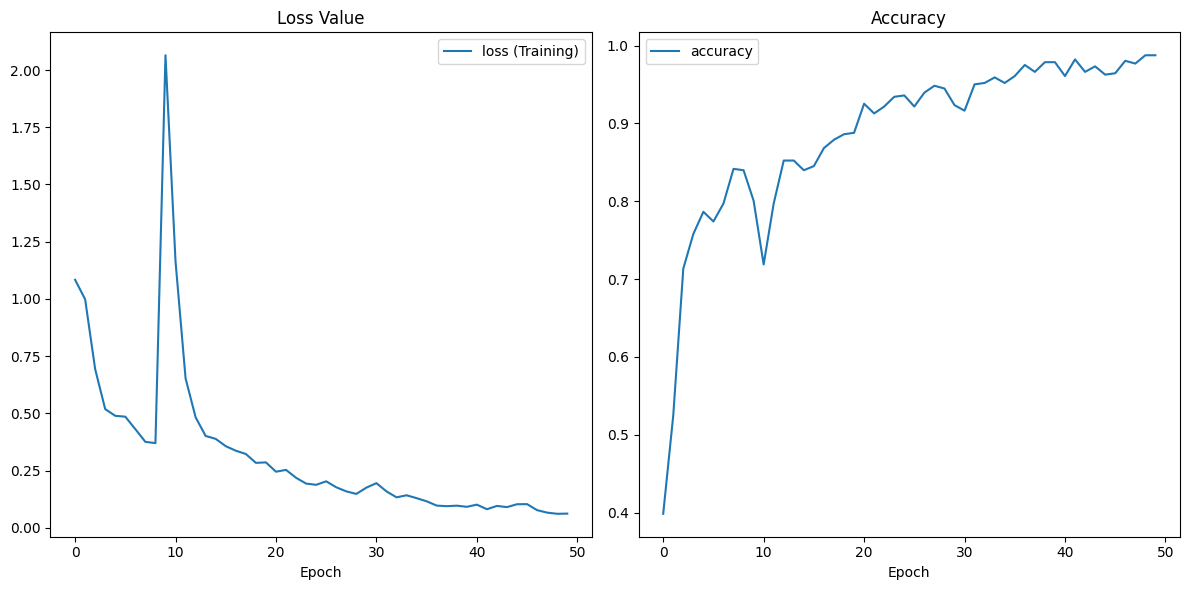

Test loss: 0.24866071343421936
Test accuracy: 0.9132231404958677
Accuracy Score: 0.9132231404958677
F1 Score: 0.8950424842594291
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       115
         1.0       0.98      0.74      0.85        70
         2.0       0.75      1.00      0.86        57

    accuracy                           0.91       242
   macro avg       0.91      0.91      0.90       242
weighted avg       0.93      0.91      0.91       242



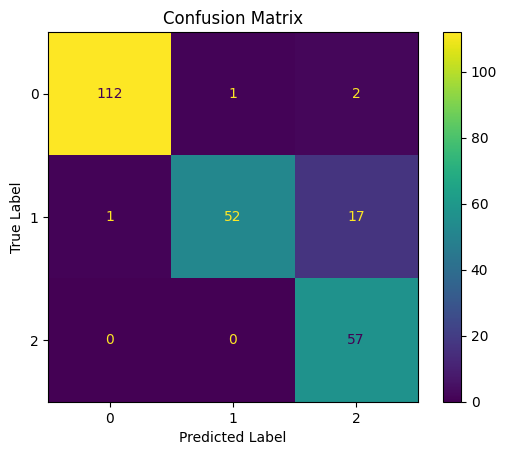

In [3]:
# Define the branched model
def build_branched_model2(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model2(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=50, batch_size=32, validation_split=0.0, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [5]:
# model_name = "FTP_LEVER_3Cnv4B_GMP_97"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model2)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 ConvLayers

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_0 (Conv1D) │ (None, 100, 128)  │     25,728 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_0 (Conv1D) │ (None, 100, 64)   │      6,464 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_0 (Conv1D) │ (None, 100, 64)   │      6,464 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 11, 128)   │    327,808 │ conv1d_1_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 11, 128)   │    163,968 │ conv1d_2_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 11, 128)   │    163,968 │ conv1d_3_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 2, 256)    │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 2, 128)    │    131,200 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 2, 128)    │    131,200 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 2, 256)    │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 2, 128)    │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 2, 128)    │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 1, 512)    │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 1, 128)    │     32,896 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 1, 128)    │     32,896 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 128)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ gap1d_1_1[0][0],

 Total params: 1,648,195 (6.29 MB)

 Trainable params: 1,648,195 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3211 - loss: 1.0833
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4273 - loss: 0.9955
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5990 - loss: 0.8603
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7961 - loss: 0.5868
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8023 - loss: 0.5593
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9032 - loss: 0.3447
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9241 - loss: 0.2309
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9450 - loss: 0.2048
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9514 - loss: 0.1636
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9579 - loss: 0.1550
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9557 - loss: 0.1362
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9653 - loss: 0.0898
Epo

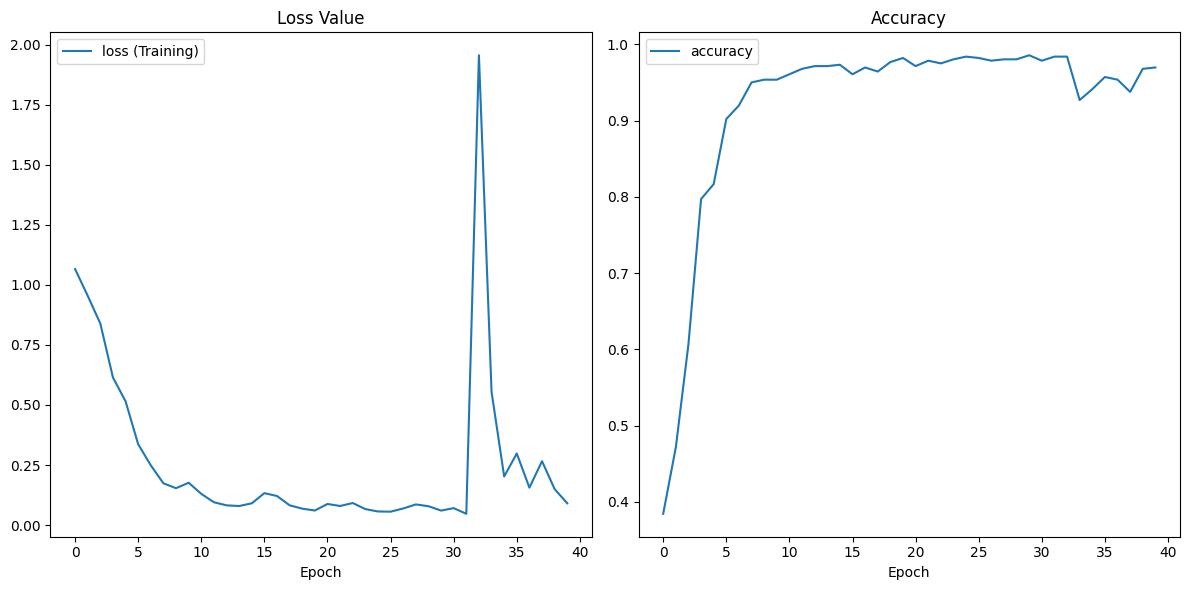

Test loss: 0.3490315079689026
Test accuracy: 0.9628099173553719
Accuracy Score: 0.9628099173553719
F1 Score: 0.9583826974157565
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       115
         1.0       0.93      0.94      0.94        70
         2.0       0.95      0.96      0.96        57

    accuracy                           0.96       242
   macro avg       0.96      0.96      0.96       242
weighted avg       0.96      0.96      0.96       242



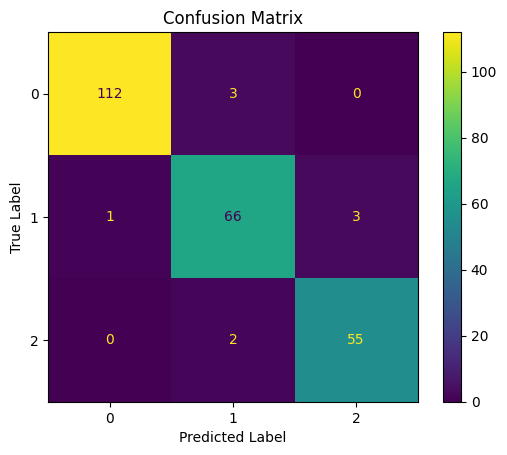

In [4]:
# Define the branched model
def build_branched_model3(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128, kernel_size=20, strides=8, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.3, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128, kernel_size=20, strides=8, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.3, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128, kernel_size=20, strides=8, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.3, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=128, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')

    # Dense layers
    dense = Dense(128, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    return model


# Create and compile the model
model = build_branched_model3(input_shape1, input_shape2, input_shape3)
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=50, batch_size=64, validation_split=0.0, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# model_name = "FTP_LEVER_4Cnv100GMP_97"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model3)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)